### Neural Networks to fit $y = \sin(\theta)$ and $\theta = \arcsin(y)$

In [1]:
# Library imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time

# Aliases
keras = tf.keras

In [2]:
# Local imports
from utils import gpu_grow_memory, TimeHistory, EpochLoss, plot_loss_hist
from utils import load_vartbl, save_vartbl, plot_style

from polar_coord import make_data_sin, make_dataset_sin
from polar_coord import make_model_sin_math, make_model_odd
from polar_coord import compile_and_fit, make_model_autoencoder

In [3]:
# Grow GPU memory (must be first operation in TF)
gpu_grow_memory()

In [4]:
# Plot style 
plot_style()

In [5]:
# Lightweight serialization
fname = '../pickle/polar_coord.pickle'
vartbl = load_vartbl(fname)

## Create datasets for $\theta \in [-\pi/2, \pi/2]$ and $y \in [-1, 1]$

In [6]:
# Make datasets for sin
n = 3600
data_sin = make_data_sin(n)
ds_p2c, ds_c2p, ds_p2p, ds_c2c = make_dataset_sin(n)

In [7]:
# Unpack one example batch
# theta, y = list(ds_p2c.take(1))[0]
# theta, y = theta.numpy(), y.numpy()

# Review data contents
# print(f'theta: min={np.min(theta):+8.5}, max={np.max(theta):+8.5}')
# print(f'    y: min={np.min(y):+8.5}, max={np.max(y):+8.5}')

In [8]:
theta = data_sin['theta']
y = data_sin['y']

## Deterministic Mathematical Models

In [9]:
# Mathematical models
math_p2c, math_c2p, math_p2p, math_c2c = make_model_sin_math()

In [10]:
# Set loss function and optimizer
loss = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam()
metrics = [keras.metrics.MeanAbsoluteError()]

# Set save_freq in terms of SAMPLES; this is every 500 epochs
epoch_size = n+1
save_freq = 500 * epoch_size

In [11]:
# Compile the math models
math_p2c.compile(loss=loss, optimizer=optimizer, metrics=metrics)
math_c2p.compile(loss=loss, optimizer=optimizer, metrics=metrics)
math_p2p.compile(loss=loss, optimizer=optimizer, metrics=metrics)
math_c2c.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [12]:
# Evaluate the p2c math model
math_p2c.evaluate(ds_p2c)

1/1 [==============================] - 0s 67ms/step - loss: 4.6015e-16 - mean_absolute_error: 8.6908e-09


[4.601469428267544e-16, 8.690771e-09]

In [13]:
# Evaluate the c2p math model
math_c2p.evaluate(ds_c2p)

1/1 [==============================] - 0s 60ms/step - loss: 6.4945e-13 - mean_absolute_error: 9.5310e-08


[6.494470217686954e-13, 9.5309716e-08]

In [14]:
# Evaluate the p2p math model
math_p2p.evaluate(theta, theta)

3601/3601 [==============================] - 0s 42us/sample - loss: 6.4904e-13 - mean_absolute_error: 9.3136e-08


[6.490446467481708e-13, 9.313639e-08]

In [15]:
# Evaluate the c2c math model
math_c2c.evaluate(y, y)

3601/3601 [==============================] - 0s 44us/sample - loss: 7.0153e-16 - mean_absolute_error: 1.2527e-08


[7.01525834862032e-16, 1.2526948e-08]

## Functions for visualizing neural network outputs $y = \sin(\theta)$

In [16]:
def plot_pred_sin(model, theta):
    # Predictions of the model
    y_pred = model.predict(theta)
    y_pred = y_pred.reshape((-1,))
    
    # Plot predictions
    fig, ax = plt.subplots(figsize=[16,9])
    ax.set_title(f'$y = sin(\\theta)$ in {model.name}')
    ax.set_xlabel('$\\theta$')
    ax.set_ylabel('$y$')
    ax.set_xlim(-np.pi/2.0, np.pi/2.0)
    ax.set_xticks(np.linspace(-np.pi/2.0, np.pi/2.0, 5))
    ax.set_xticklabels(['$-\pi/2$', '$-\pi/4$', '0', '$\pi/4$', '$\pi/2$'])
    ax.set_ylim(-1.05, 1.05)
    ax.set_yticks(np.linspace(-1.0, 1.0, 9))
    ax.plot(theta, y, color='blue', label='$\sin(\\theta)$', linewidth=4.0)
    ax.plot(theta, y_pred, color='red', label='NN$(\\theta)$', linewidth=2.0)
    ax.grid()
    ax.legend()
    return fig, ax

In [17]:
def plot_error_sin(model, theta):
    # Predictions of the model
    y_pred = model.predict(theta)
    y_pred = y_pred.reshape((-1,))
    error = y_pred - np.sin(theta)
    
    # Plot errors
    fig, ax = plt.subplots(figsize=[16,9])
    ax.set_title(f'Error for $y = sin(\\theta)$ in {model.name}')
    ax.set_xlabel('$\\theta$')
    ax.set_ylabel('error = $\sin(\\theta)$ - NN($\\theta$)')
    ax.set_xlim(-np.pi/2.0, np.pi/2.0)
    ax.set_xticks(np.linspace(-np.pi/2.0, np.pi/2.0, 5))
    ax.set_xticklabels(['$-\pi/2$', '$-\pi/4$', '0', '$\pi/4$', '$\pi/2$'])
    ax.plot(theta, error, color='red', label='error', linewidth=4.0)
    ax.grid()
    # ax.legend()
    return fig, ax

## Neural networks for $y = \sin(\theta)$

### Network Design 1: [64]
(model_sin_64 has one layer with 64 hidden units)

In [21]:
# Build the NN model of y=sin(theta)
model_sin_64 = make_model_odd(func_name='sin', 
                              input_name='theta',
                              output_name='y',
                              hidden_sizes=[64])

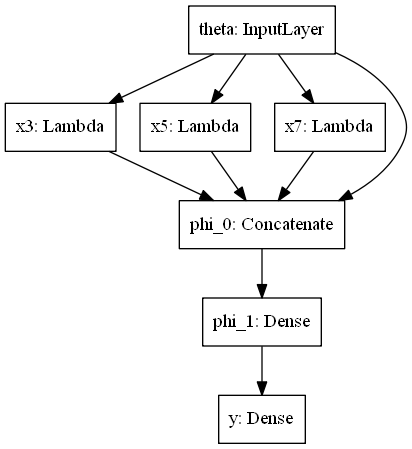

In [23]:
keras.utils.plot_model(model_sin_64)

In [24]:
model_sin_64.summary()

Model: "model_sin_[64]"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
theta (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
x3 (Lambda)                     (None, 1)            0           theta[0][0]                      
__________________________________________________________________________________________________
x5 (Lambda)                     (None, 1)            0           theta[0][0]                      
__________________________________________________________________________________________________
x7 (Lambda)                     (None, 1)            0           theta[0][0]                      
_____________________________________________________________________________________

**Load the network and its loss history if available; otherwise train it**

In [25]:
loss=keras.losses.MeanSquaredError()

optimizer=keras.optimizers.Adam(learning_rate=1.0E-3)
# optimizer=keras.optimizers.Adadelta(learning_rate=1.0E-1)
# optimizer=keras.optimizers.SGD(learning_rate=1.0E-3, momentum=0.5)

try:
    model_sin_64.load_weights('../models/polar_model_sin_[64].h5')
    model_sin_64.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    hist_sin_64 = vartbl['hist_sin_64']
    print('Loaded model_sin_64.')
except:
    hist = compile_and_fit(model=model_sin_64, 
                           ds=ds_p2c, 
                           epochs=10000,
                           loss=loss, 
                           optimizer=optimizer,
                           metrics=metrics,
                           save_freq=save_freq)
    hist_sin_64 = hist.history
    vartbl['hist_sin_64'] = hist_sin_64
    save_vartbl(vartbl, fname)

Loaded model_sin_64.


In [26]:
model_sin_64.evaluate(ds_p2c)

1/1 [==============================] - 0s 471ms/step - loss: 4.0609e-08 - mean_absolute_error: 1.6796e-04


[4.060898461943907e-08, 0.00016795515]

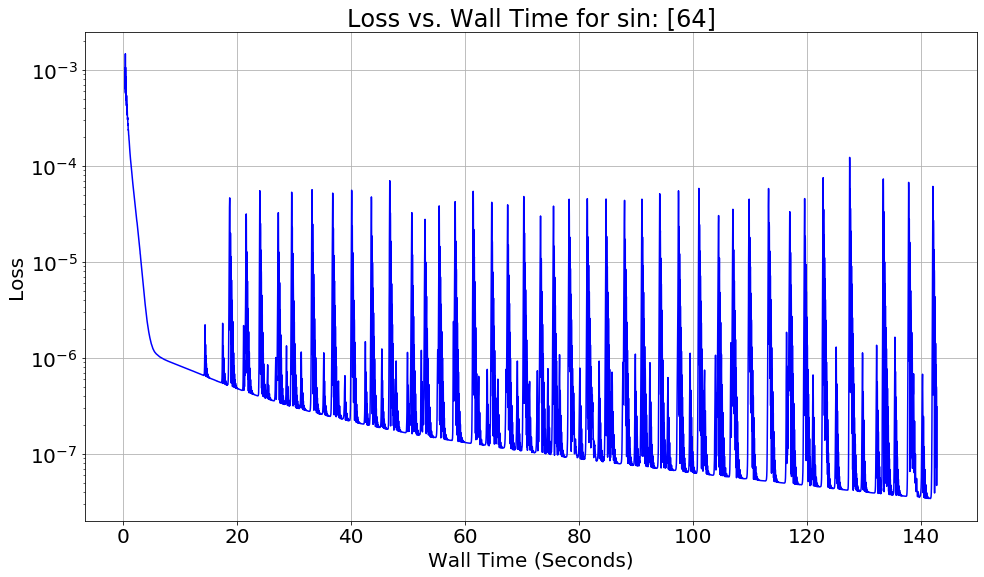

In [27]:
fig, ax = plot_loss_hist(hist_sin_64, 'sin: [64]')

In [29]:
# fig, ax = plot_pred_sin(model_sin_64, theta)

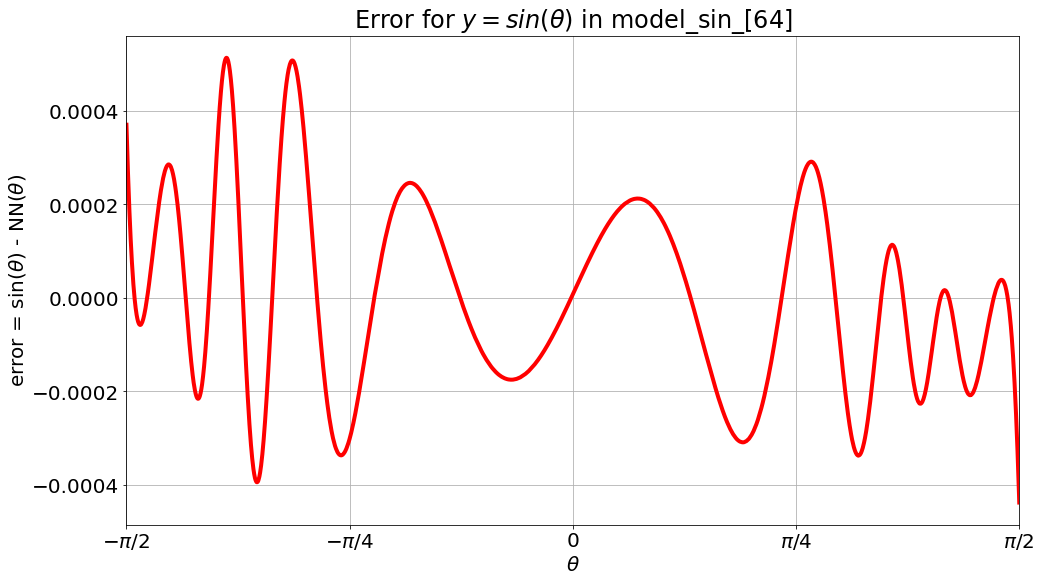

In [30]:
fig, ax = plot_error_sin(model_sin_64, theta)

### Network Design 2: [16, 16]
(model_sin_16_16 has two layers with 16 hidden units each)

In [31]:
model_sin_16_16 = make_model_odd(func_name='sin', 
                                 input_name='theta',
                                 output_name='y', 
                                 hidden_sizes=[16, 16])

In [32]:
model_sin_16_16.summary()

Model: "model_sin_[16, 16]"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
theta (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
x3 (Lambda)                     (None, 1)            0           theta[0][0]                      
__________________________________________________________________________________________________
x5 (Lambda)                     (None, 1)            0           theta[0][0]                      
__________________________________________________________________________________________________
x7 (Lambda)                     (None, 1)            0           theta[0][0]                      
_________________________________________________________________________________

**Load the network and its loss history if available; otherwise train it**

In [33]:
loss=keras.losses.MeanSquaredError()
optimizer=keras.optimizers.Adam(learning_rate=1.0E-3)

try:
    model_sin_16_16.load_weights('../models/polar_model_sin_[16, 16].h5')
    model_sin_16_16.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    hist_sin_16_16 = vartbl['hist_sin_16_16']
    print('Loaded model_sin_16_16.')
except:
    hist = compile_and_fit(model=model_sin_16_16, 
                           ds=ds_p2c, 
                           epochs=10000,
                           loss=loss, 
                           optimizer=optimizer,
                           metrics=metrics,
                           save_freq=save_freq)
    hist_sin_16_16 = hist.history
    vartbl['hist_sin_16_16'] = hist_sin_16_16
    save_vartbl(vartbl, fname)

Loaded model_sin_16_16.


In [34]:
model_sin_16_16.evaluate(ds_p2c)

1/1 [==============================] - 0s 94ms/step - loss: 1.4789e-07 - mean_absolute_error: 3.2034e-04


[1.4789002023007924e-07, 0.0003203424]

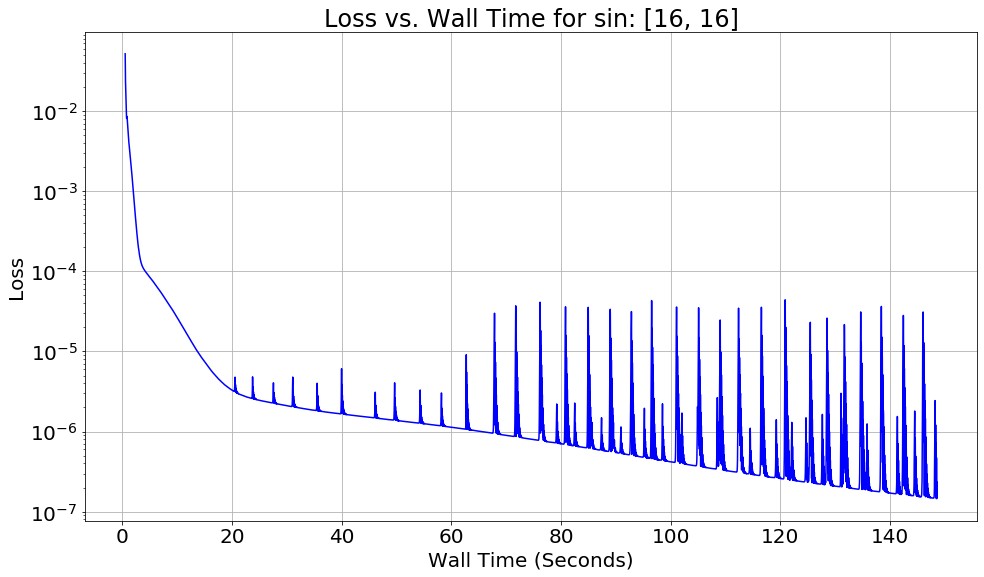

In [35]:
fig, ax = plot_loss_hist(hist_sin_16_16, 'sin: [16, 16]')

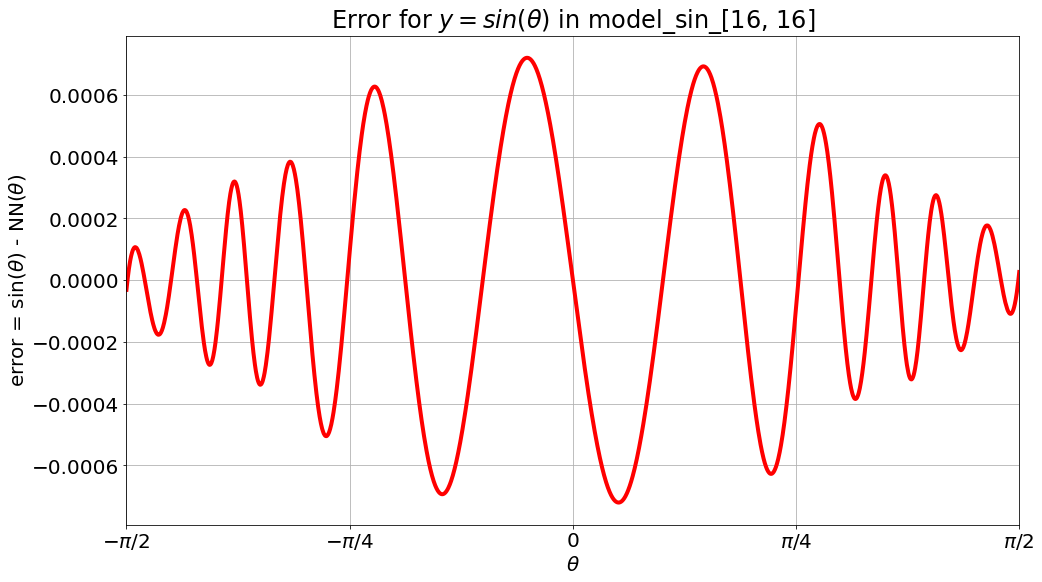

In [36]:
fig, ax = plot_error_sin(model_sin_16_16, theta)

## Neural networks for $\theta = \arcsin(y)$

## Functions for visualizing neural network outputs $\theta = \arcsin(y)$

In [37]:
def plot_pred_arcsin(model, y):
    # Predictions of the model
    theta_pred = model.predict(y)
    theta_pred = theta_pred.reshape((-1,))
    
    # Plot predictions
    fig, ax = plt.subplots(figsize=[16,9])
    ax.set_title(f'$\\theta = \\arcsin(y)$ for {model.name}')
    ax.set_xlabel('$y$')
    ax.set_ylabel('$\\theta$')
    ax.set_xlim(-1.05, 1.05)
    ax.set_xticks(np.linspace(-1.0, 1.0, 9))
    ax.set_ylim(-np.pi/2.0, np.pi/2.0)
    ax.set_yticks(np.linspace(-np.pi/2.0, np.pi/2.0, 5))
    ax.set_yticklabels(['$-\pi/2$', '$-\pi/4$', '0', '$\pi/4$', '$\pi/2$'])
    ax.plot(y, theta, color='blue', label='$\\arcsin(y)$', linewidth=4.0)
    ax.plot(y, theta_pred, color='red', label='NN$(y)$', linewidth=2.0)
    ax.grid()
    ax.legend()
    return fig, ax

In [38]:
def plot_error_arcsin(model, y):
    # Predictions of the model
    theta_pred = model.predict(y)
    theta_pred = theta_pred.reshape((-1,))
    error = theta - theta_pred
    
    # Plot predictions
    fig, ax = plt.subplots(figsize=[16,9])
    ax.set_title(f'Error in $\\theta = \\arcsin(y)$ for {model.name}')
    ax.set_xlabel('$y$')
    ax.set_ylabel('$\\theta$')
    ax.set_xlim(-1.05, 1.05)
    ax.set_xticks(np.linspace(-1.0, 1.0, 9))
    ax.plot(y, error, color='red', label='error', linewidth=4.0)
    ax.grid()
    ax.legend()
    return fig, ax

### Network Design 1: [64]

In [45]:
model_arcsin_64 = make_model_odd(func_name='arcsin', 
                                 input_name = 'y',
                                 output_name='theta', 
                                 hidden_sizes=[64])

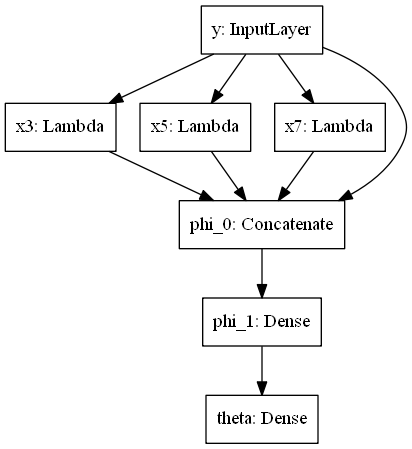

In [46]:
keras.utils.plot_model(model_arcsin_64)

In [47]:
model_arcsin_64.summary()

Model: "model_arcsin_[64]"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
y (InputLayer)                  [(None, 1)]          0                                            
__________________________________________________________________________________________________
x3 (Lambda)                     (None, 1)            0           y[0][0]                          
__________________________________________________________________________________________________
x5 (Lambda)                     (None, 1)            0           y[0][0]                          
__________________________________________________________________________________________________
x7 (Lambda)                     (None, 1)            0           y[0][0]                          
__________________________________________________________________________________

In [60]:
loss=keras.losses.MeanSquaredError()
optimizer=keras.optimizers.Adam(learning_rate=1.0E-3)

try:
    model_arcsin_64.load_weights('../models/polar_model_arcsin_[64].h5')
    model_arcsin_64.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    hist_sin_64 = vartbl['hist_arcsin_64']
    print('Loaded model_arcsin_64.')
except:
    hist = compile_and_fit(model=model_arcsin_64, 
                           ds=ds_c2p, 
                           epochs=10000,
                           loss=loss, 
                           optimizer=optimizer,
                           metrics=metrics,
                           save_freq=save_freq)
    hist_arcsin_64 = hist.history
    vartbl['hist_arcsin_64'] = hist_arcsin_64
    save_vartbl(vartbl, fname)

Epoch 0001; loss 9.52e-01; elapsed 0:00:00
Epoch 0500; loss 1.43e-03; elapsed 0:00:08
Epoch 1000; loss 8.32e-04; elapsed 0:00:16
Epoch 1500; loss 5.78e-04; elapsed 0:00:24
Epoch 2000; loss 5.17e-04; elapsed 0:00:31
Epoch 2500; loss 4.93e-04; elapsed 0:00:39
Epoch 3000; loss 4.68e-04; elapsed 0:00:47
Epoch 3500; loss 4.35e-04; elapsed 0:00:55
Epoch 4000; loss 3.84e-04; elapsed 0:01:02
Epoch 4500; loss 3.07e-04; elapsed 0:01:10
Epoch 5000; loss 2.12e-04; elapsed 0:01:18
Epoch 5500; loss 1.45e-04; elapsed 0:01:26
Epoch 6000; loss 1.07e-04; elapsed 0:01:34
Epoch 6500; loss 8.78e-05; elapsed 0:01:41
Epoch 7000; loss 8.04e-05; elapsed 0:01:49
Epoch 7500; loss 7.54e-05; elapsed 0:01:56
Epoch 8000; loss 7.08e-05; elapsed 0:02:04
Epoch 8500; loss 6.71e-05; elapsed 0:02:11
Epoch 9000; loss 6.42e-05; elapsed 0:02:18
Epoch 9500; loss 6.23e-05; elapsed 0:02:26
Epoch 10000; loss 6.11e-05; elapsed 0:02:33


In [61]:
model_arcsin_64.evaluate(ds_c2p)

1/1 [==============================] - 0s 90ms/step - loss: 6.0863e-05 - mean_absolute_error: 0.0048


[6.086289795348421e-05, 0.004813082]

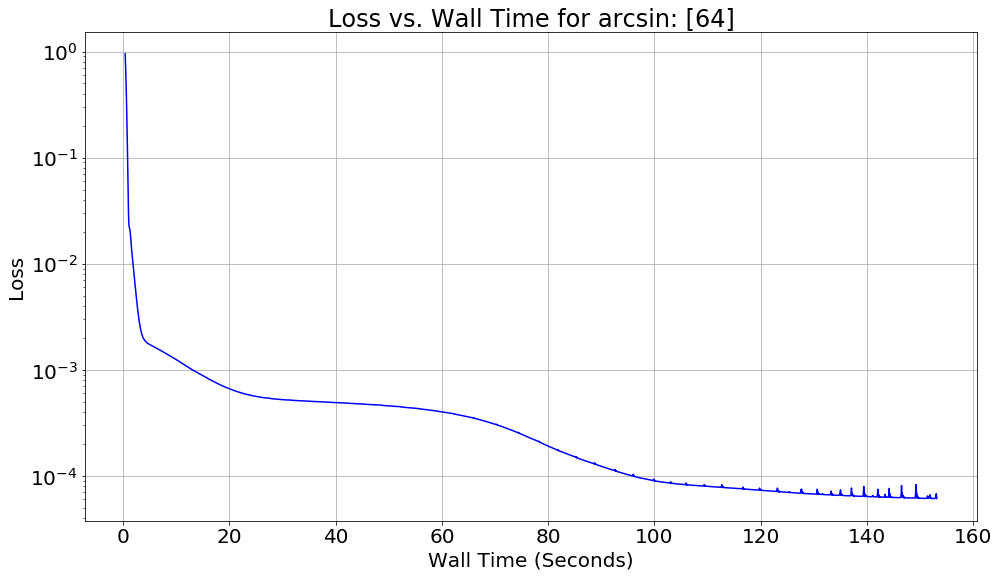

In [63]:
fig, ax = plot_loss_hist(hist_arcsin_64, 'arcsin: [64]')

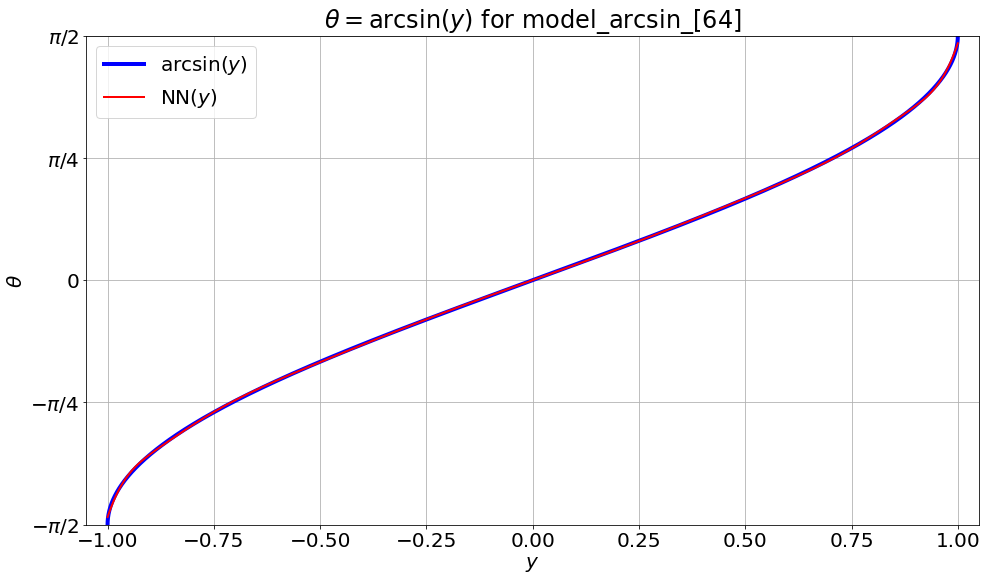

In [64]:
fig, ax = plot_pred_arcsin(model_arcsin_64, y)

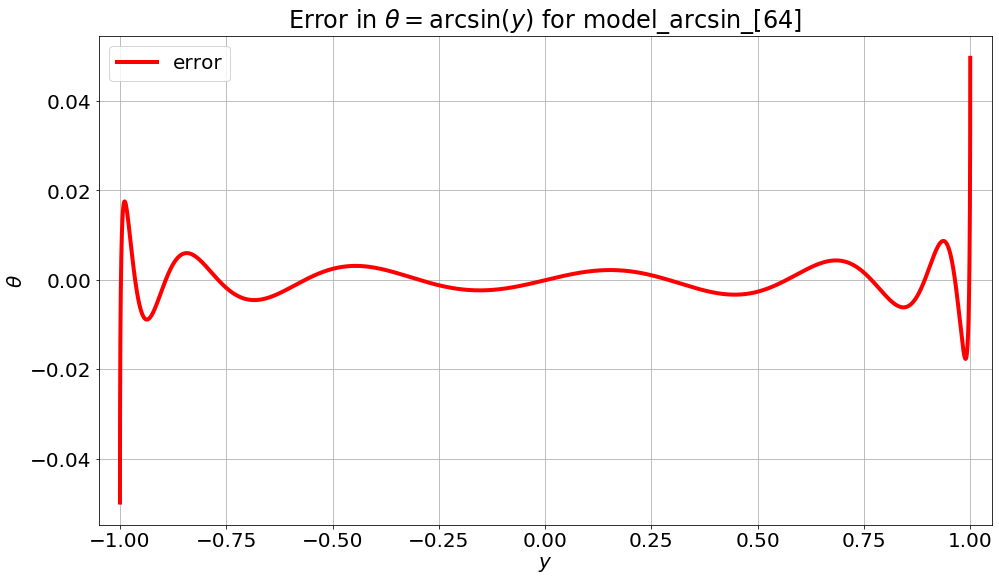

In [65]:
fig, ax = plot_error_arcsin(model_arcsin_64, y)

### Network Design 2: [16, 16]

In [66]:
model_arcsin_16_16 = make_model_odd(func_name='arcsin', 
                                    input_name = 'y',
                                    output_name='theta', 
                                    hidden_sizes=[16, 16])

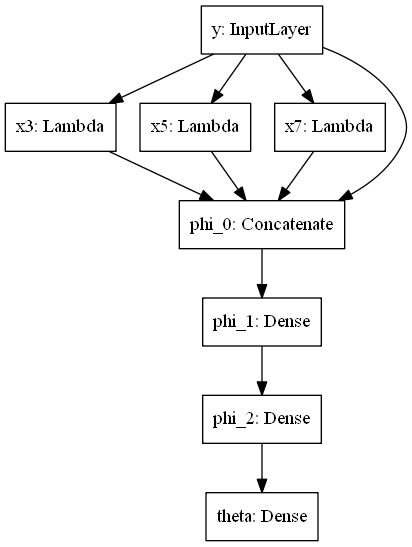

In [67]:
keras.utils.plot_model(model_arcsin_16_16)

In [68]:
model_arcsin_16_16.summary()

Model: "model_arcsin_[16, 16]"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
y (InputLayer)                  [(None, 1)]          0                                            
__________________________________________________________________________________________________
x3 (Lambda)                     (None, 1)            0           y[0][0]                          
__________________________________________________________________________________________________
x5 (Lambda)                     (None, 1)            0           y[0][0]                          
__________________________________________________________________________________________________
x7 (Lambda)                     (None, 1)            0           y[0][0]                          
______________________________________________________________________________

In [69]:
loss=keras.losses.MeanSquaredError()
optimizer=keras.optimizers.Adam(learning_rate=1.0E-3)

try:
    model_arcsin_16_16.load_weights('../models/polar_model_arcsin_[16, 16].h5')
    model_arcsin_16_16.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    hist_arcsin_16_16 = vartbl['hist_arcsin_16_16']
    print('Loaded model_arcsin_16_16.')
except:
    hist = compile_and_fit(model=model_arcsin_16_16, 
                           ds=ds_c2p, 
                           epochs=10000,
                           loss=loss, 
                           optimizer=optimizer,
                           metrics=metrics,
                           save_freq=save_freq)
    hist_arcsin_16_16 = hist.history
    vartbl['hist_arcsin_16_16'] = hist_arcsin_16_16
    save_vartbl(vartbl, fname)

Loaded model_arcsin_16_16.


In [70]:
model_arcsin_16_16.evaluate(ds_c2p)

1/1 [==============================] - 0s 90ms/step - loss: 4.9504e-05 - mean_absolute_error: 0.0037


[4.950350557919592e-05, 0.0037371162]

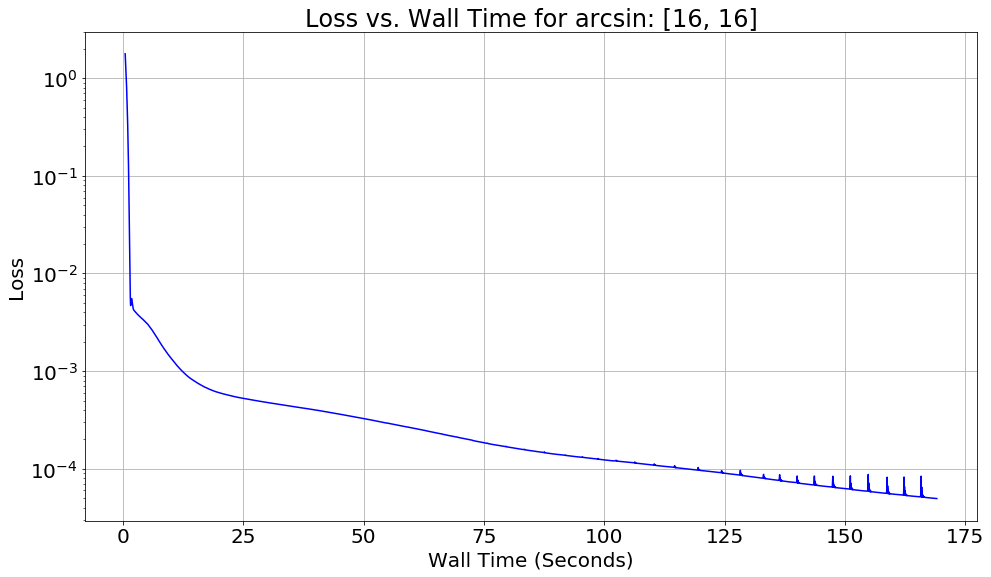

In [71]:
fig, ax = plot_loss_hist(hist_arcsin_16_16, 'arcsin: [16, 16]')

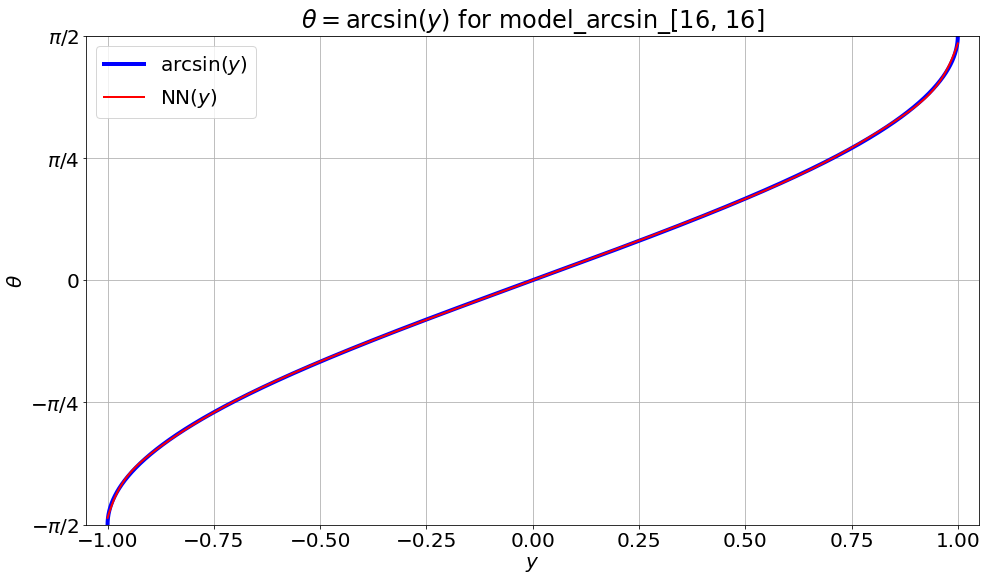

In [72]:
fig, ax = plot_pred_arcsin(model_arcsin_16_16, y)

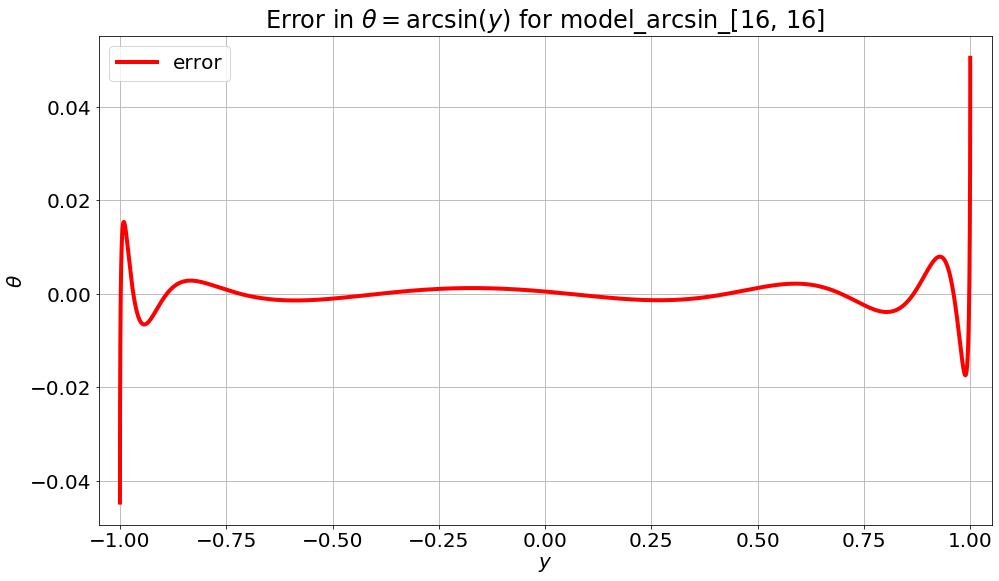

In [73]:
fig, ax = plot_error_arcsin(model_arcsin_16_16, y)

In [84]:
# copies of model instances
model_sin = keras.models.clone_model(model_sin_16_16)
model_sin.set_weights(model_sin_16_16.get_weights())
model_arcsin = keras.models.clone_model(model_arcsin_16_16)
model_arcsin.set_weights(model_arcsin_16_16.get_weights())

# remove special characters from model names
# otherwise make_model_autoencoder fails with invalid scope name due to [16, 16] in model names
model_sin._name = 'model_sin'
model_arcsin._name = 'model_arcsin'

In [85]:
model_p2p, model_c2c = make_model_autoencoder(
    model_p2c = model_sin,
    model_c2p = model_arcsin)

In [88]:
model_p2p.compile(loss=loss, optimizer=optimizer, metrics=metrics)
model_p2p.evaluate(ds_p2p)

1/1 [==============================] - 0s 264ms/step - loss: 5.1122e-05 - mean_absolute_error: 0.0038


[5.112238068250008e-05, 0.0037568314]

In [87]:
model_c2c.compile(loss=loss, optimizer=optimizer, metrics=metrics)
model_c2c.evaluate(ds_c2c)

1/1 [==============================] - 0s 123ms/step - loss: 1.8200e-06 - mean_absolute_error: 0.0011


[1.819986891860026e-06, 0.001110055]